In [2]:
# This notebook is for using the antenna S matrix which includes the plasma infornt of it.

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from TWA_Design_Tools import TWA_Design_Toolkit
from TWA_skrf_Toolkit import TWA_skrf_Toolkit as rftoolkit
import skrf as rf
from scipy.optimize import minimize
import csv
import h5py

In [3]:
def save_figure_data_to_hdf5(fig, filename='figure_data.h5'):
    with h5py.File(filename, 'w') as hdf:
        for ax_idx, ax in enumerate(fig.get_axes()):
            ax_group = hdf.create_group(f'axes_{ax_idx}')
            for line_idx, line in enumerate(ax.get_lines()):
                line_group = ax_group.create_group(f'line_{line_idx}')
                x_data = line.get_xdata()
                y_data = line.get_ydata()
                line_group.create_dataset('x', data=x_data)
                line_group.create_dataset('y', data=y_data)

In [4]:
# this notebook is to test that everything in center fed mode works as expected
num_straps = 13
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

# settings to create the rf toolkit object 
capz0 = 9.3506
antz0 = 30
freqs_for_fullant = np.arange(92,101, 1)# np.arange(81,112, 1)
print(freqs_for_fullant)
# capfile = 'circ_model/S11_cap_81to111MHz_16_cmcapbox.csv'
capfile = 'circ_model/S11_cap_81to111MHz_20cmcapbox.csv'
antfile = 'circ_model/fixed_bigscan_full_CF_13strap_2passive_plasma.csv' 
myrfTWA = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
                    antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile, center_fed_mode=True)

# add items to geometry
ar = 1.5e-2
d = 15.625e-2
s0 = 16e-2
wstrap = 8e-2
l = 15e-2
ts = 0.5e-2
tbox = 1e-2
h = .5e-2
t_cap_extend = 0.25e-2
wcap = wstrap + 2*t_cap_extend # 1 cm on either side
wcapbox = wcap + 2*h
tdiv = myrfTWA.geometry_dict['s_rez'] - 2*h - wcap 
dcap = ts + 2*t_cap_extend
dcapbox = dcap + 2*h
lcapbox = 10e-2
lcut = 6e-2
ldeembed = 5e-2
lfeed = 10e-2

myrfTWA.add_to_geometry('ar', ar)
myrfTWA.add_to_geometry('d', d)
myrfTWA.add_to_geometry('s0', s0)
myrfTWA.add_to_geometry('wstrap', wstrap)
myrfTWA.add_to_geometry('l', l)
myrfTWA.add_to_geometry('ts', ts)
myrfTWA.add_to_geometry('tbox', tbox)
myrfTWA.add_to_geometry('h', h)
myrfTWA.add_to_geometry('t_cap_extended', t_cap_extend)
myrfTWA.add_to_geometry('wcap', wcap)
myrfTWA.add_to_geometry('wcapbox', wcapbox)
myrfTWA.add_to_geometry('tdiv', tdiv)
myrfTWA.add_to_geometry('dcap', dcap)
myrfTWA.add_to_geometry('dcapbox', dcapbox)
myrfTWA.add_to_geometry('lcapbox', lcapbox)
myrfTWA.add_to_geometry('lcut', lcut)
myrfTWA.add_to_geometry('ldeembed', ldeembed)
myrfTWA.add_to_geometry('lfeed', lfeed)

myrfTWA.print_geometry()

k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
[ 92  93  94  95  96  97  98  99 100]
num_straps:     13
s_rez:          0.15625
lamda0:         3.1228381041666666
ar:             0.015
d:              0.15625
s0:             0.16
wstrap:         0.08
l:              0.15
ts:             0.005
tbox:           0.01
h:              0.005
t_cap_extended: 0.0025
wcap:           0.085
wcapbox:        0.095
tdiv:           0.061249999999999985
dcap:           0.01
dcapbox:        0.02
lcapbox:        0.1
lcut:           0.06
ldeembed:       0.05
lfeed:          0.1


In [39]:
# New area for secondary peak cancelation 
# try out the knew optimization function. Start with very low alpha and beta, and lamda largeish. 
#bounds = [(0.05, 0.154)]*7#[(0.02, 0.095)]*5
bounds = [(0.05, 0.194)]*7#[(0.02, 0.095)]*5
freq_bounds = (93,97)#(92, 100)
s11cutoff = -45 # TODO this used to be -45 dB 

# new settings 
alpha = 100e3#200000 # 10,000 worked well 
gamma = 10e3#100000
lam1 = 1000#1000#10.017e6 # phase op
lam2 = 40e3#40000 # power ratio op 
target_npar = 5.2#5.6 # TODO: change back to 5
target_PR = 2 # TODO: I do not know what the desired power ratio is. 
npar_bounds = [0, 10]
num_npars = 100
workers = 4

# secondary peak cancelation 
npar_secondary_peak_cancelation = np.linspace(0.88,3.111, 10)#np.append(np.linspace(0.88,3.111, 10), np.linspace(6,7.5, 10))
epsilon = 30e3#15007.012

res = myrfTWA.run_differential_evolution_global_op_npar_match_low_npar_zero_cancel_image_currents_reduce_secondary_peaks( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            gamma_npar_op=gamma,
                                            target_npar=target_npar,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            lam1_image_current_phase_op=lam1,
                                            lam2_image_current_mag_op=lam2,
                                            target_power_ratio_image_current_op=target_PR,
                                            npar_array_secondary_peak_cancelation=npar_secondary_peak_cancelation,
                                            epsilon_secondary_peak_cancelation=epsilon,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False,
                                            workers=workers)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.14279808 0.13514431 0.11873601 0.11909531 0.114278   0.12946138
 0.15423587]
Average absolute error is : 5.41e+03
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.14279809 0.13514431 0.11873601 0.11909531 0.114278   0.12946138
 0.15423587]
Average absolute error is : 5.41e+03
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.14279808 0.13514432 0.11873601 0.11909531 0.114278   0.12946138
 0.15423587]
Average absolute error is : 5.41e+03
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.14279808 0.13514431 0.11873602 0.11909531 0.114278   0.12946138
 0.15423587]
Average absolute error is : 5.41e+03
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.14279808 0.13514431 0.11873601 0.11909532 0.114278   0.12946138
 0.15423587]
Average absolute error is : 5.41e+03
-------------------------

In [40]:
# check the phase diff and power ratio between the first and second straps (including any passive straps)
lengths_found = res.x.tolist()
#lengths_found = [0.13254054, 0.09346692, 0.0602741, 0.07834545, 0.06088853, 0.11657295]
print('final lengths:', lengths_found)
phase_diff, PR = myrfTWA.get_phase_diff_and_PR_straps_1_and_2(lengths=lengths_found.copy(), 
                                                        freq=myrfTWA.freq_for_npar_op,
                                                        power=[1,0,0],
                                                        phase=[0,0,0],
                                                        symetric_mode=True,
                                                        one_cap_type_mode=False,
                                                        end_cap_mode=False)

print(f'The phase difference is {phase_diff*180/np.pi} deg')
print(f'The power ratio I_2^2 / I_1^2 = {PR}')

final lengths: [0.14279808133859212, 0.13514431344086358, 0.11873601062611154, 0.11909531122670285, 0.1142780035301999, 0.12946138429241502, 0.1542358701129262]
The phase difference is 168.34339124279583 deg
The power ratio I_2^2 / I_1^2 = 2.006621864365965


In [36]:
# use this cell to store good cap combos 
# good spectrum, resoannce at 97 MHz
[0.14214559597312906, 0.13626280063402707, 0.11374946212178846, 0.12097381536949635, 0.11731841417263386, 0.12684162992549047, 0.15373231017033231]

[0.14214559597312906,
 0.13626280063402707,
 0.11374946212178846,
 0.12097381536949635,
 0.11731841417263386,
 0.12684162992549047,
 0.15373231017033231]

final lengths: [0.14279808133859212, 0.13514431344086358, 0.11873601062611154, 0.11909531122670285, 0.1142780035301999, 0.12946138429241502, 0.1542358701129262]


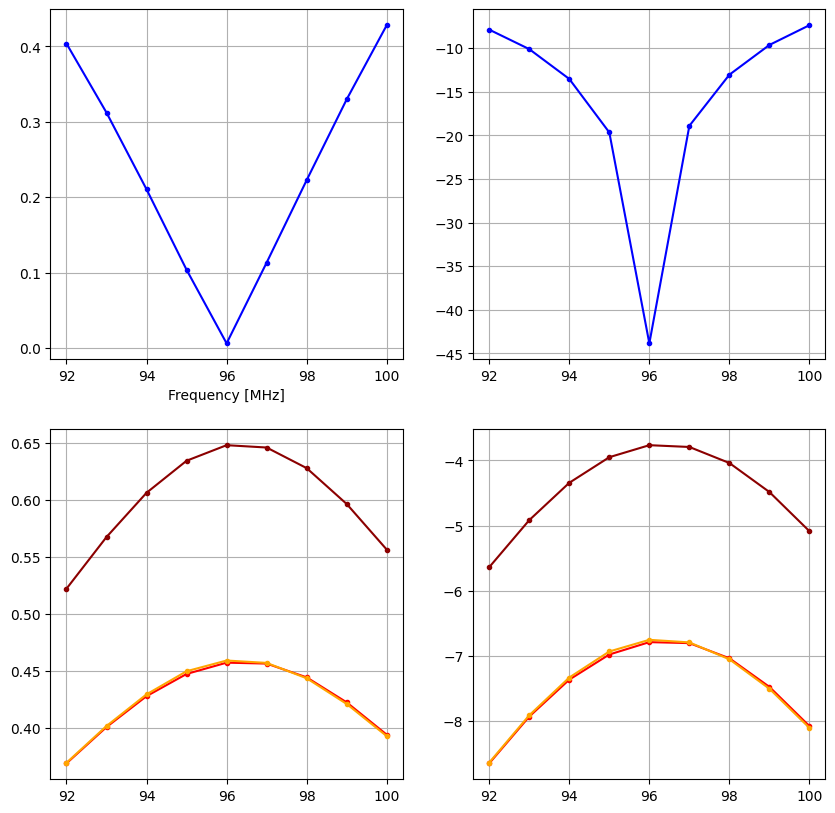

In [41]:
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,0].set_xlabel('Frequency [MHz]')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

port indicies [1, 3, 5]
[ 0.23690083+0.07771641j -0.23690083-0.07771641j  0.09702533+0.03578862j
 -0.09702533-0.03578862j  0.09741331+0.03595307j -0.09741331-0.03595307j
  0.15556527-0.01511607j -0.15556527+0.01511607j -0.15020805+0.0526357j
  0.15020805-0.0526357j  -0.30003944-0.20367496j  0.30003944+0.20367496j
  0.13943731-0.09142643j -0.13943731+0.09142643j  0.30856239+0.2045482j
 -0.30856239-0.2045482j  -0.08747276+0.2111965j   0.08747276-0.2111965j
 -0.41225929-0.42304499j  0.41225929+0.42304499j -0.08920333+0.20959375j
  0.08920333-0.20959375j  0.30919482+0.20494622j -0.30919482-0.20494622j
  0.13991877-0.09059289j -0.13991877+0.09059289j -0.30090198-0.20408629j
  0.30090198+0.20408629j -0.1508328 +0.05281505j  0.1508328 -0.05281505j
  0.15590626-0.01571102j -0.15590626+0.01571102j]
--
[-0.03898374+0.12820005j  0.01739169-0.18901427j  0.35728364-0.13048346j
 -0.11095332+0.25044149j -0.34309801+0.04643408j  0.14212086-0.33196153j
  0.3739052 +0.29538685j  0.14357567-0.33387049j -

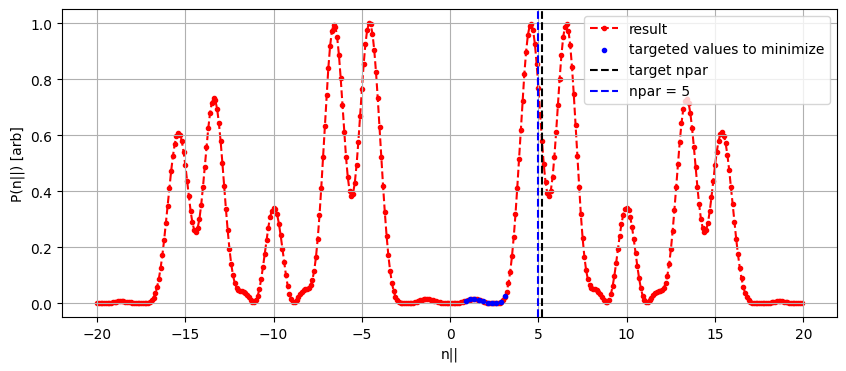

In [42]:
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad
strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

npar_array = np.arange(0, 10, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

result_circ_model_secondary_peak = np.array([], dtype='complex')
for i in range(npar_secondary_peak_cancelation.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_secondary_peak_cancelation[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model_secondary_peak = np.append(result_circ_model_secondary_peak, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', 
         label='result', marker='.', zorder=1)
plt.scatter(npar_secondary_peak_cancelation, result_circ_model_secondary_peak/np.max(np.real(result_circ_model)), 
            color='blue', marker='.', label='targeted values to minimize', zorder=2)
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

plt.axvline(x=target_npar, ymin=0, ymax=1, color='k', linestyle='--', label='target npar')
plt.axvline(x=5, ymin=0, ymax=1, color='blue', linestyle='--', label='npar = 5')
plt.legend()

print('npar_secondary_peak_cancelation', npar_secondary_peak_cancelation)

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 [Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80')])

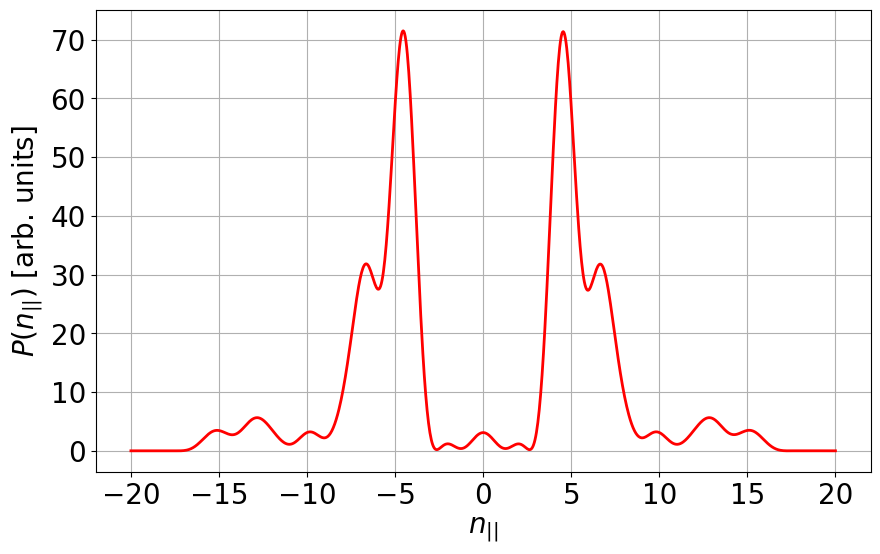

In [45]:
# figure from comsol npar plot 
plt.figure(figsize=(10,6))
data_for_npar_plot = np.loadtxt('npar_96MHz_dvac_0_55')
npar = data_for_npar_plot[:,0]
powers = data_for_npar_plot[:,1]
plt.plot(npar, powers, color='red', linewidth=2)
plt.grid()
plt.xlabel(r'$n_{||}$', fontsize=20)
plt.ylabel(r'$P(n_{||})$ [arb. units]', fontsize=20)
plt.xticks(fontsize=20)  # Set x-axis tick label font size
plt.yticks(fontsize=20)  # Set y-axis tick label font size

[-35.498]


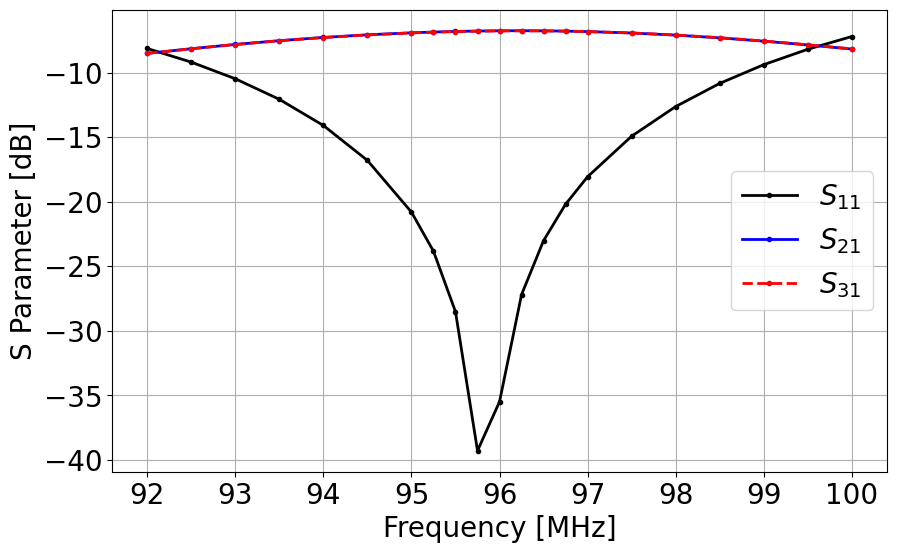

In [5]:
# build up the S11, S21, S31 matrix 
filename = 'S11_over_f_plasma_dvac_0_55.csv'
dataset = np.loadtxt(filename, delimiter=',')
fd = dataset[:, 0]
S11db = dataset[:,1]
S21db = dataset[:,2]
S31db = dataset[:,3]

fig = plt.figure(figsize=(10,6))
plt.plot(fd, S11db, color='black', linewidth=2, label=r'$S_{11}$', marker='.')
plt.plot(fd, S21db, color='blue', linewidth=2, label=r'$S_{21}$', marker='.')
plt.plot(fd, S31db, color='red', linestyle='--', linewidth=2, label=r'$S_{31}$', marker='.')
plt.grid()
plt.xlabel('Frequency [MHz]', fontsize=20)
plt.ylabel(r'S Parameter [dB]', fontsize=20)
plt.xticks(fontsize=20)  # Set x-axis tick label font size
plt.yticks(fontsize=20)  # Set y-axis tick label font size
plt.legend(fontsize=20, loc='right')

print(S11db[np.where(fd == 96)])
save_figure_data_to_hdf5(fig, 'figure21.h5')

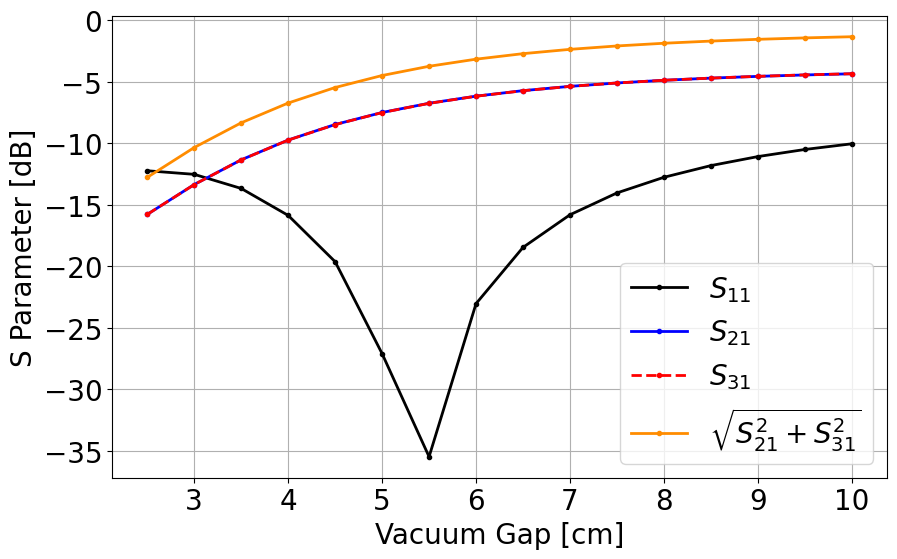

In [6]:
# build up the S11, S21, S31 matrix 
filename = 'impedence_match_0_55_optimized_under_density_fluctuations.txt'
dataset = np.loadtxt(filename)
dvac = dataset[:, 0]
S11db = dataset[:,2]
S21db = dataset[:,3]
S31db = dataset[:,4]

S21 = 10**(S21db/20)
S31 = 10**(S31db/20)
Strans_array = np.real(20*np.log10(np.sqrt(S21**2 + S31**2)))

fig = plt.figure(figsize=(10,6))
plt.plot(dvac*100, S11db, color='black', linewidth=2, label=r'$S_{11}$', marker='.')
plt.plot(dvac*100, S21db, color='blue', linewidth=2, label=r'$S_{21}$', marker='.')
plt.plot(dvac*100, S31db, color='red', linestyle='--', linewidth=2, label=r'$S_{31}$', marker='.')
plt.plot(dvac*100, Strans_array, linewidth=2, label=r'$\sqrt{S_{21}^2 + S_{31}^2}$', color='darkorange', marker='.')
plt.grid()
plt.xlabel('Vacuum Gap [cm]', fontsize=20)
plt.ylabel(r'S Parameter [dB]', fontsize=20)
plt.xticks(fontsize=20)  # Set x-axis tick label font size
plt.yticks(fontsize=20)  # Set y-axis tick label font size
plt.legend(fontsize=20, loc='lower right')

#print(S11db[np.where(fd == 96)])
save_figure_data_to_hdf5(fig, 'figure22.h5')

In [34]:
# plotting the nparallel power spectrum for the plasma optimized antenna. Step one: load the data. 

npar_data_plasma_op = np.loadtxt('npar_96MHz_dvac_scan')
#npar_data_plasma_op = np.loadtxt('npar_plot2.txt')
print(npar_data_plasma_op.shape)

dvac_array = np.arange(2.5, 10.5, 0.5)



(1000, 17)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.3        0.34666667 0.39333333 0.44       0.48666667 0.53333333
 0.58       0.62666667 0.67333333 0.72       0.76666667 0.81333333
 0.86       0.90666667 0.95333333 1.        ]


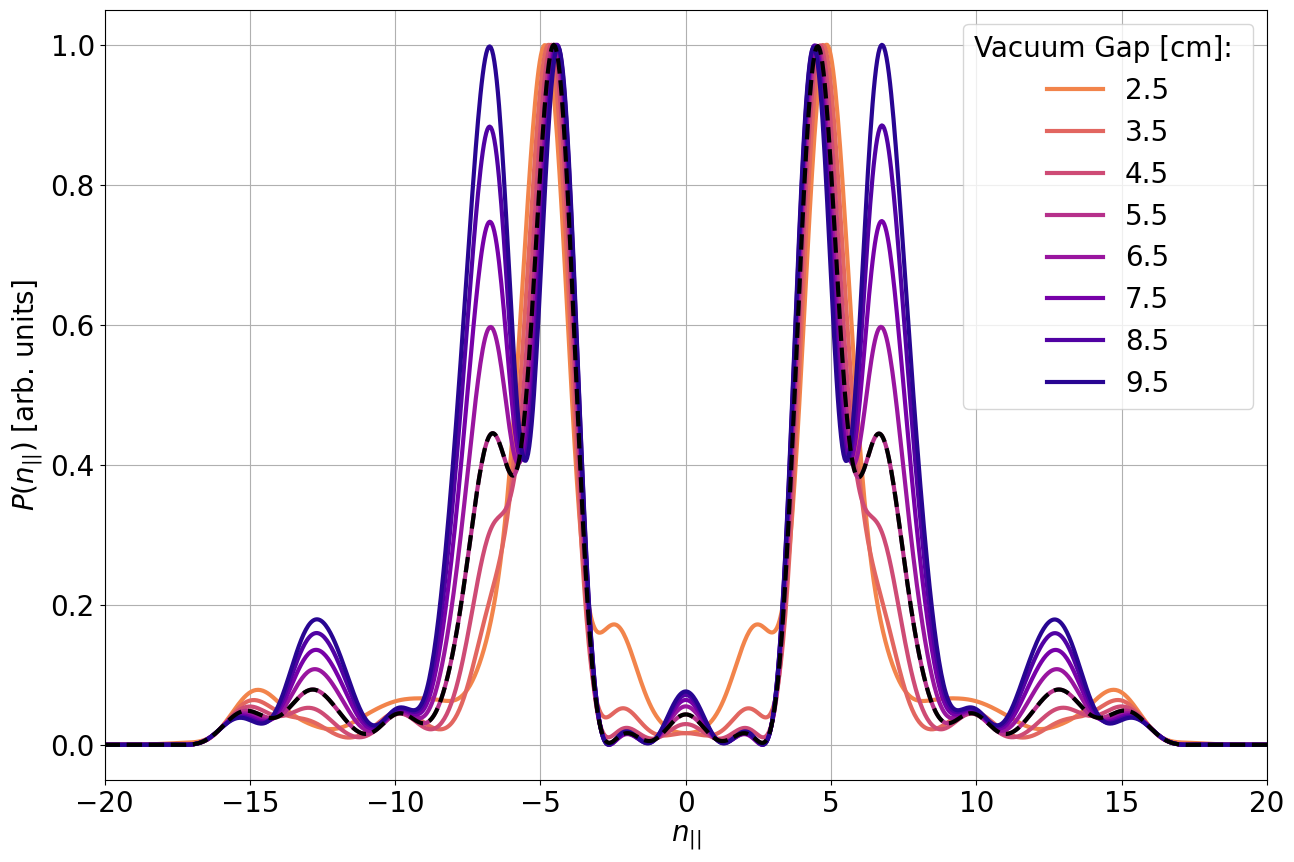

In [35]:
from matplotlib import cm
# plotting the nparallel power spectrum for the plasma optimized antenna. 

# clean script for looping through the Ey slicegrid data and plotting the n|| 
# spectrum. Then, do the same for building the S11,21,31 plot. 
freq = 96e6

fig = plt.figure(figsize=(15,10))
plt.xticks(fontsize=20)  # Set x-axis tick label font size
plt.yticks(fontsize=20)  # Set y-axis tick label font size
plt.legend(fontsize=20)
plt.xlim(-20,20)
plt.grid()
# set up colormap
start = 0.3
stop = 1
number_of_lines= dvac_array.shape[0]
cm_subsection = np.linspace(start, stop, number_of_lines)
print(cm_subsection) 
front_string = 'Vacuum Gap [cm]: '
colors = [ cm.plasma_r(x) for x in cm_subsection ]
for j in range(number_of_lines):
    dvac_float = dvac_array[j]
    npar_array = npar_data_plasma_op[:, 0]
    power_spectrum = npar_data_plasma_op[:, j+1]
    if (j+1) % 2 !=0:
        plt.plot(npar_array, power_spectrum/np.max(power_spectrum), linewidth=3, label=str(dvac_float),color=colors[j])
        
plt.plot(npar_array, npar_data_plasma_op[:, 7]/np.max(npar_data_plasma_op[:, 7]), linewidth=3, color='black', linestyle='--')
plt.xlabel(r'$n_{||}$', fontsize=20)
plt.ylabel(r'$P(n_{||})$ [arb. units]', fontsize=20)
plt.legend(fontsize=20, title=front_string, title_fontsize=20)
save_figure_data_to_hdf5(fig, 'figure23.h5')

[0.   0.12 0.24 0.36 0.48 0.6 ]


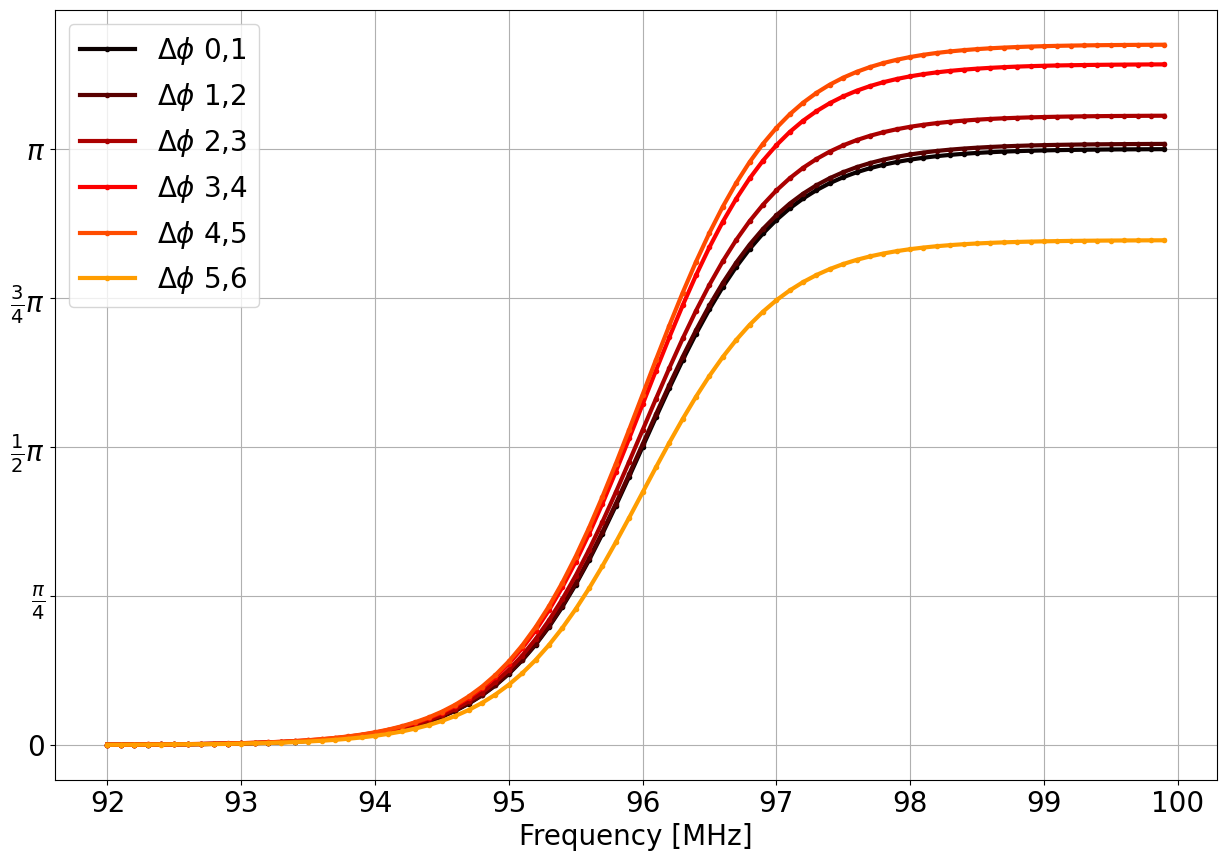

In [10]:
# new figure for phase difference
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.random import rand

fig, ax = plt.subplots(figsize=(15,10))
# ax.set_xticks(fontsize=20)  # Set x-axis tick label font size
# ax.set_yticks(fontsize=20)  # Set y-axis tick label font size

from matplotlib.ticker import MultipleLocator, FuncFormatter

# Define a function to format ticks as multiples of pi
def format_func(x, pos):
    denominator = 4  # e.g., π/4 intervals
    numerator = int(np.round(x / (np.pi / denominator)))
    if numerator == 0:
        return "0"
    elif numerator == 1:
        return r"$\frac{\pi}{" + f"{denominator}" + r"}$"
    elif numerator == denominator:
        return r"$\pi$"
    elif numerator == -1:
        return r"$-\frac{\pi}{" + f"{denominator}" + r"}$"
    elif numerator == -denominator:
        return r"$-\pi$"
    elif numerator == 2*denominator:
        return r"$2\pi$"
    elif numerator == -2*denominator:
        return r"$-2\pi$"
    elif numerator %2 ==0:
        return r"$\frac{{{}}}{{{}}}\pi$".format(int(numerator/2), int(denominator/2))
    else:
        return r"$\frac{{{}}}{{{}}}\pi$".format(numerator, denominator)

# Create data and plot

# Set locator and formatter
ax.yaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
# number of phase differences 
num_phase_diffs = 6

# set up colormap
start = 0
stop = .6
number_of_lines= num_phase_diffs
cm_subsection = np.linspace(start, stop, number_of_lines)
print(cm_subsection) 
front_string = 'Vacuum Gap [cm]: '
colors = [ cm.hot(x) for x in cm_subsection ]

# fake data to practice 
example_fdata = np.arange(92, 100, 0.1)
phase_array = np.pi*(np.tanh(example_fdata-96)+1)/2
# load up fake data
data = np.zeros((num_phase_diffs, example_fdata.shape[0]))
for i in range(num_phase_diffs):
    data[i,:] = phase_array*(1+.1*i*(rand()-0.5))

for i in range(num_phase_diffs):
    ax.plot(example_fdata, data[i,:], linewidth=3, label=r'$\Delta$$\phi$ ' + f'{i},{i+1}', color=colors[i], marker='.')

ax.legend(fontsize=20)
ax.grid()
ax.set_xlabel('Frequency [MHz]', fontsize=20)

for label in ax.get_xticklabels():
    label.set_fontsize(20)          # set size

for label in ax.get_yticklabels():
    label.set_fontsize(20)          # set size
#pltt.plot(example_data, phase_array)

In [15]:

# now, do this for real.
phase_data_path = 'strap_phases_with_plasma_image_current_cancelation_strap_first.txt'
import re

def parse_complex(s):
    """Convert a string like '1.2+3.4i' or '-0.001+0.002i' to a Python complex number."""
    s = s.replace('i', 'j')  # Python uses 'j' for imaginary numbers
    return complex(s)

data = []
frequencies = []

with open(phase_data_path, "r") as f:
    for line in f:
        # Skip header lines
        if not re.match(r'^\d', line.strip()):
            continue
        parts = line.strip().split()
        freq = float(parts[0])
        complex_vals = [parse_complex(p) for p in parts[1:]]
        frequencies.append(freq)
        data.append(complex_vals)

# Convert to NumPy arrays
frequencies = np.array(frequencies)
data = np.array(data, dtype=np.complex128) 
print(data.shape)
def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

def delta_phase(a, b):
    """
    Compute the minimal signed phase difference between angles a and b (in radians).
    The result is in the range (-π, π].
    """
    delta = (a - b) % (2 * np.pi)
    if delta > np.pi:
        delta -= 2 * np.pi
    # elif delta < -np.pi:
    #     delta += 2*np.pi
    return delta

# create phase array
mag_data = np.abs(data)
phase_data = get_phase(data)
#phase_data[phase_data < 0] += 2 * np.pi
print(phase_data.shape)
print(mag_data.shape)

(23, 7)
(23, 7)
(23, 7)


[0.  0.1 0.2 0.3 0.4 0.5 0.6]
2.0858271775220016
96.0


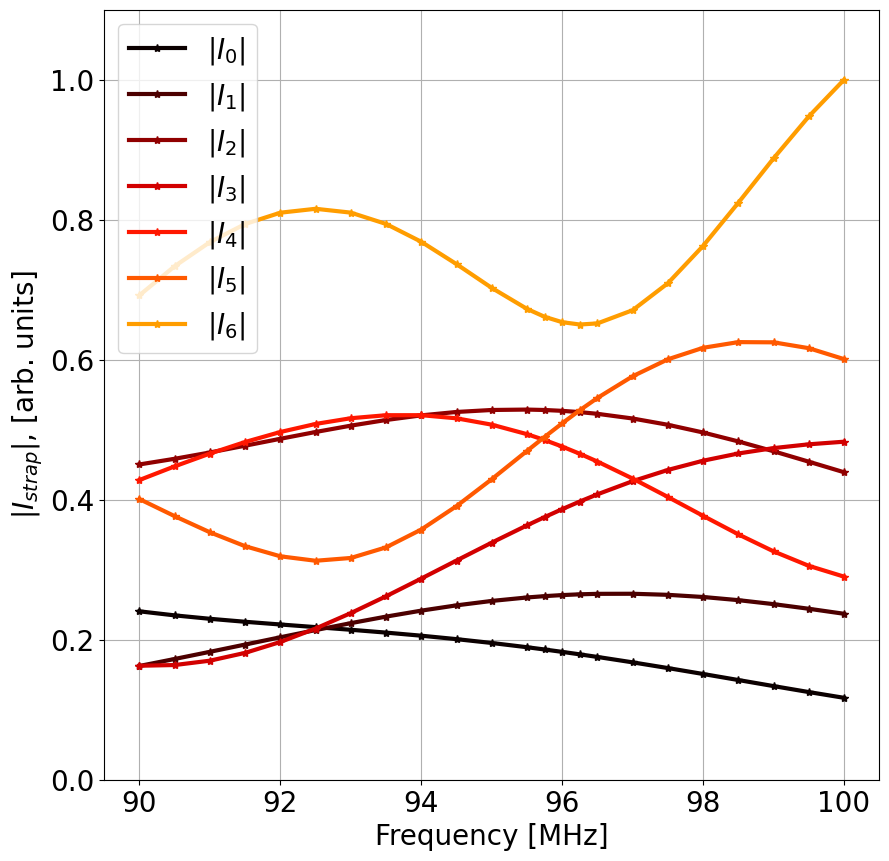

In [16]:
# plot the current magnitude 
fig, ax = plt.subplots(figsize=(10,10))
# ax.yaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
# ax.yaxis.set_major_formatter(FuncFormatter(format_func))
# number of phase differences 
num_phase = 7

# set up colormap
start = 0
stop = .6
number_of_lines= num_phase
cm_subsection = np.linspace(start, stop, number_of_lines)
print(cm_subsection) 
front_string = 'Vacuum Gap [cm]: '
colors = [ cm.hot(x) for x in cm_subsection ]

for i in range(mag_data.shape[1]):
    ax.plot(frequencies, mag_data[:,i]/np.max(mag_data), linewidth=3, label=r'$|I_{'+ f'{i}' r'}$|', color=colors[i], marker='*')

ax.legend(fontsize=20)
ax.grid()
#ax.set_ylim(-np.pi, np.pi)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Frequency [MHz]', fontsize=20)
ax.set_ylabel(r'|$I_{strap}$|, [arb. units]', fontsize=20)


for label in ax.get_xticklabels():
    label.set_fontsize(20)          # set size

for label in ax.get_yticklabels():
    label.set_fontsize(20)          # set size

print((mag_data[13,1]/mag_data[13,0])**2)
print(frequencies[13])
save_figure_data_to_hdf5(fig, 'figure25.h5')

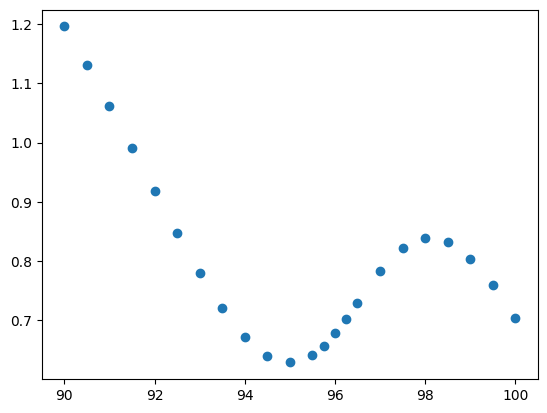

In [17]:
plt.scatter(frequencies, np.unwrap(phase_data[:,6]))
# plt.scatter(frequencies, phase_data[:,1])
# print(phase_data[0,0])
# print(phase_data[1,0])
# print( np.abs(phase_data[0,0]) - np.abs(phase_data[1,0]))

(23, 6)


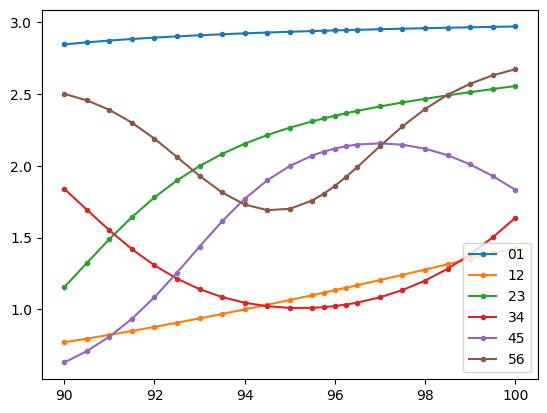

In [18]:
# build delta phi array
delta_phi = np.zeros((phase_data.shape[0], phase_data.shape[1]-1))
print(delta_phi.shape)

for f in range(delta_phi.shape[0]):
    for j in range(delta_phi.shape[1]):
        delta_phi[f,j] = delta_phase(phase_data[f,j+1], phase_data[f,j])

for i in range(6):
    plt.plot(frequencies, delta_phi[:,i], marker='.', label=f'{i}{i+1}')
plt.legend()

[0.   0.12 0.24 0.36 0.48 0.6 ]


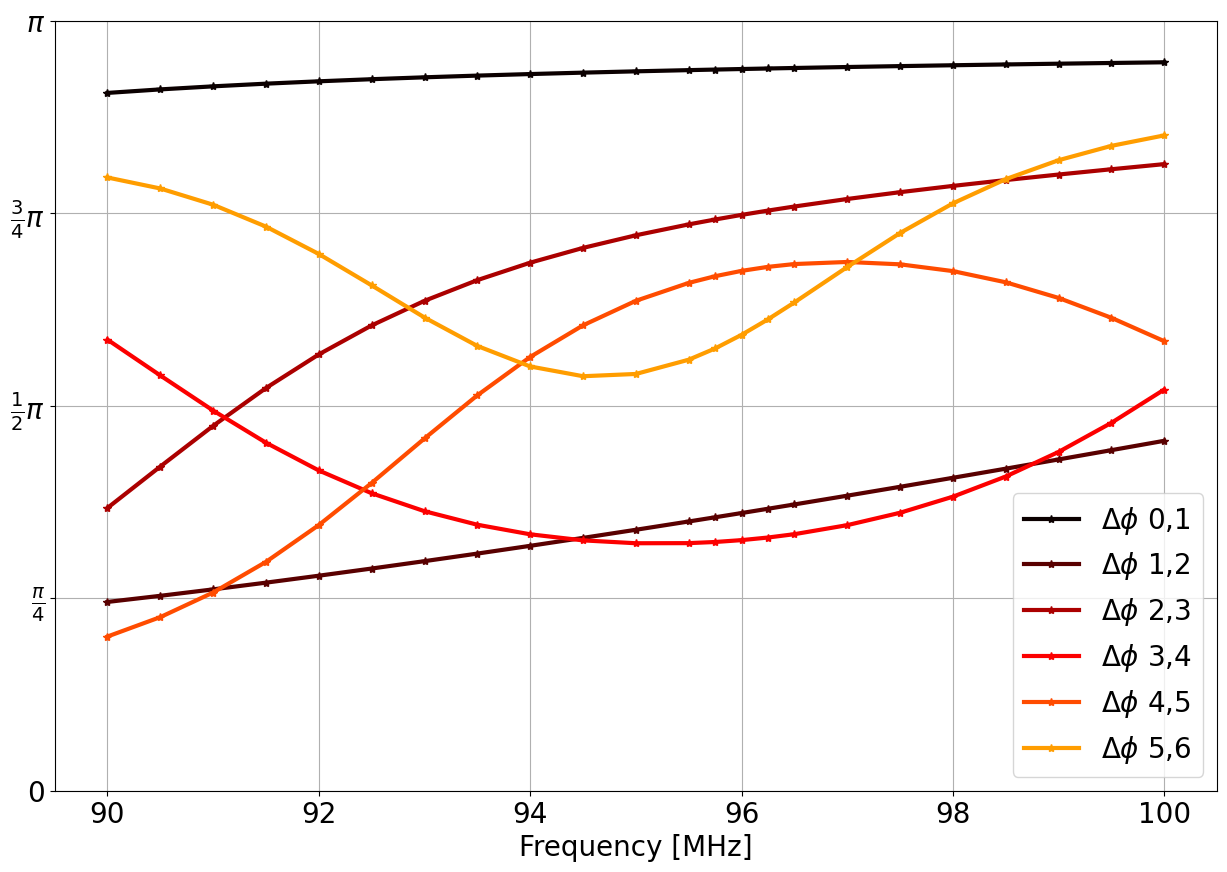

In [19]:
# now run the final plotting 
fig, ax = plt.subplots(figsize=(15,10))
ax.yaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
# number of phase differences 
num_phase_diffs = 6

# set up colormap
start = 0
stop = .6
number_of_lines= num_phase_diffs
cm_subsection = np.linspace(start, stop, number_of_lines)
print(cm_subsection) 
front_string = 'Vacuum Gap [cm]: '
colors = [ cm.hot(x) for x in cm_subsection ]

for i in range(delta_phi.shape[1]):
    ax.plot(frequencies, delta_phi[:,i], linewidth=3, label=r'$\Delta$$\phi$ ' + f'{i},{i+1}', color=colors[i], marker='*')

ax.legend(fontsize=20)
ax.grid()
ax.set_ylim(0, np.pi)
ax.set_xlabel('Frequency [MHz]', fontsize=20)

for label in ax.get_xticklabels():
    label.set_fontsize(20)          # set size

for label in ax.get_yticklabels():
    label.set_fontsize(20)          # set size
#pltt.plot(example_data, phase_array)

[0.  0.1 0.2 0.3 0.4 0.5 0.6]


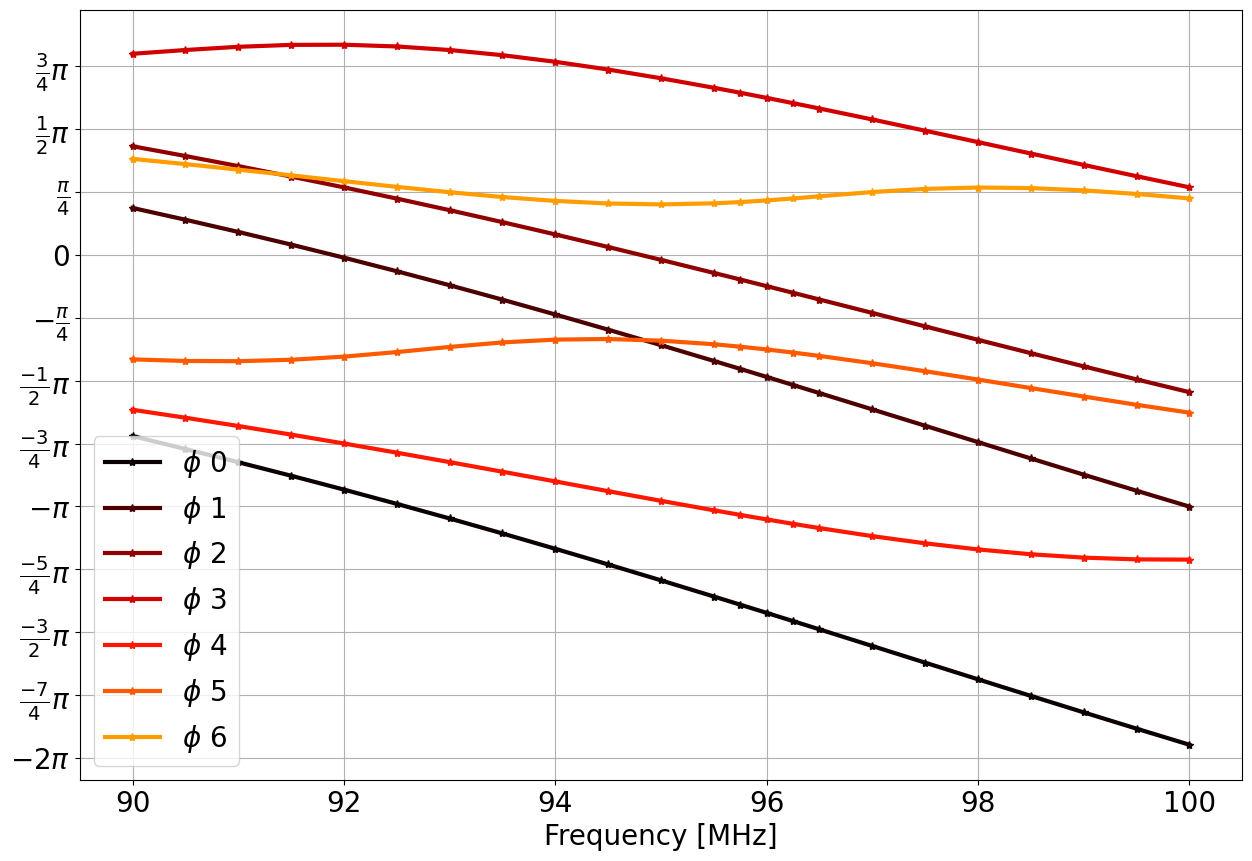

In [20]:
# plot the phases
fig, ax = plt.subplots(figsize=(15,10))
ax.yaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
# number of phase differences 
num_phase = 7

# set up colormap
start = 0
stop = .6
number_of_lines= num_phase
cm_subsection = np.linspace(start, stop, number_of_lines)
print(cm_subsection) 
front_string = 'Vacuum Gap [cm]: '
colors = [ cm.hot(x) for x in cm_subsection ]

phase_data_uw = np.zeros_like(phase_data)
for i in range(phase_data.shape[1]):
    phase_data_uw[:,i] = np.unwrap(phase_data[:,i])

for i in range(phase_data.shape[1]):
    ax.plot(frequencies, phase_data_uw[:,i], linewidth=3, label=r'$\phi$ ' + f'{i}', color=colors[i], marker='*')

ax.legend(fontsize=20)
ax.grid()
#ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel('Frequency [MHz]', fontsize=20)


for label in ax.get_xticklabels():
    label.set_fontsize(20)          # set size

for label in ax.get_yticklabels():
    label.set_fontsize(20)          # set size

[0.   0.12 0.24 0.36 0.48 0.6 ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6]


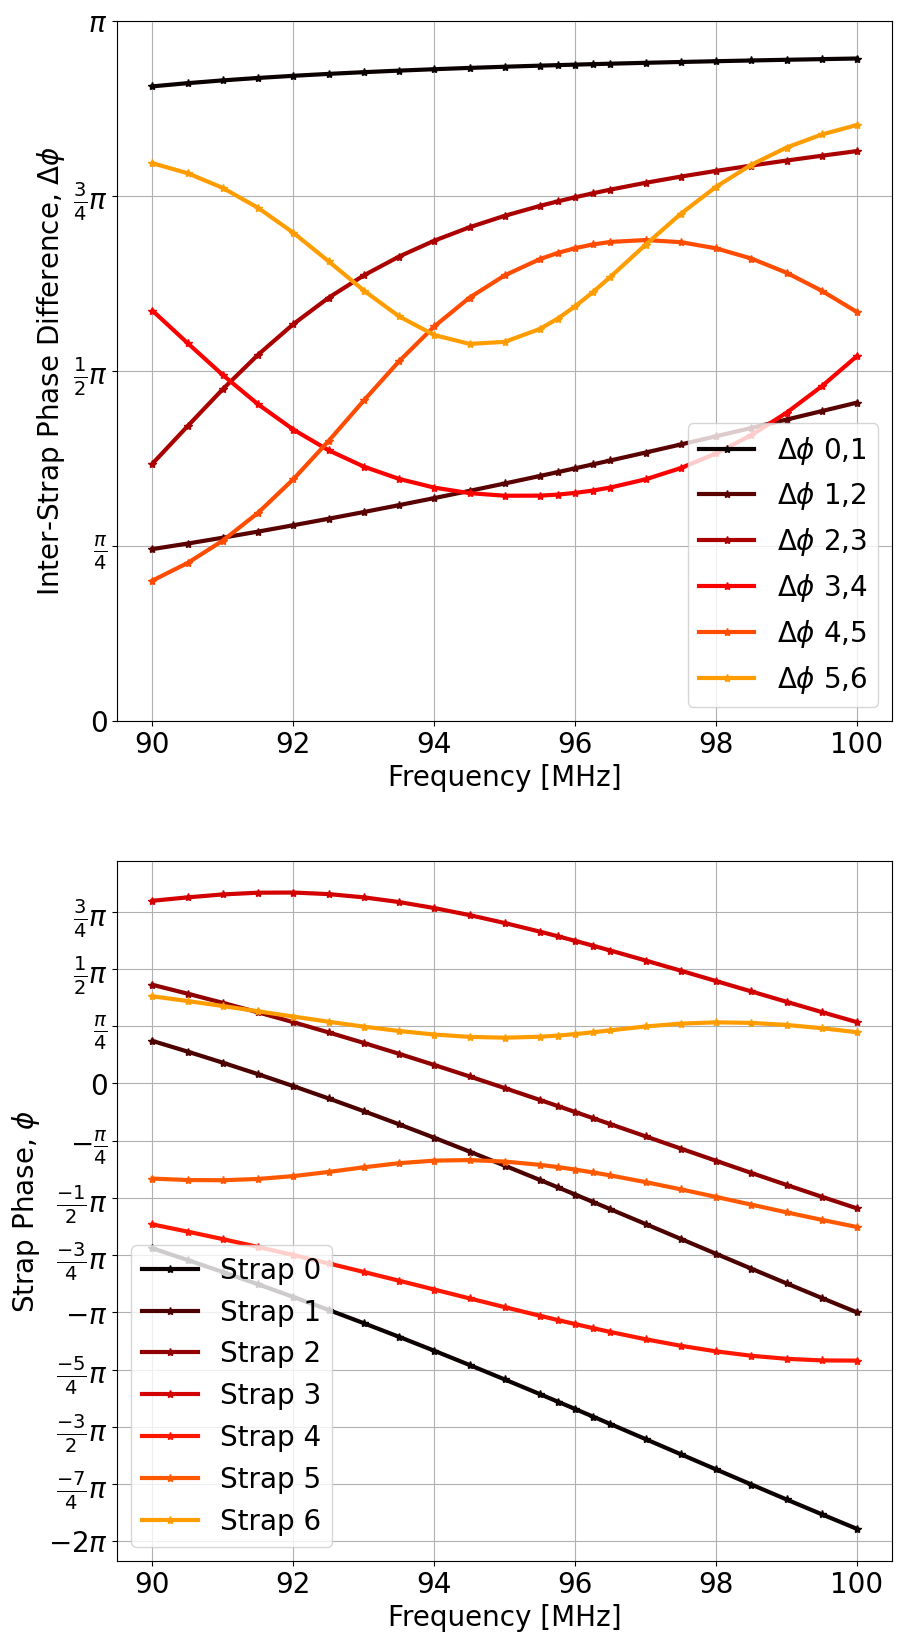

In [21]:
# now both 
fig, ax = plt.subplots(2,1, figsize=(10,20))
ax[0].yaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
ax[0].yaxis.set_major_formatter(FuncFormatter(format_func))
# number of phase differences 
num_phase_diffs = 6

# set up colormap
start = 0
stop = .6
number_of_lines= num_phase_diffs
cm_subsection = np.linspace(start, stop, number_of_lines)
print(cm_subsection) 
front_string = 'Vacuum Gap [cm]: '
colors = [ cm.hot(x) for x in cm_subsection ]

for i in range(delta_phi.shape[1]):
    ax[0].plot(frequencies, delta_phi[:,i], linewidth=3, label=r'$\Delta$$\phi$ ' + f'{i},{i+1}', color=colors[i], marker='*')

ax[0].legend(fontsize=20)
ax[0].grid()
ax[0].set_ylim(0, np.pi)
ax[0].set_xlabel('Frequency [MHz]', fontsize=20)
ax[0].set_ylabel(r'Inter-Strap Phase Difference, $\Delta$$\phi$', fontsize=20)

for label in ax[0].get_xticklabels():
    label.set_fontsize(20)          # set size

for label in ax[0].get_yticklabels():
    label.set_fontsize(20)          # set size

# phase

ax[1].yaxis.set_major_locator(MultipleLocator(base=np.pi / 4))
ax[1].yaxis.set_major_formatter(FuncFormatter(format_func))
# number of phase differences 
num_phase = 7

# set up colormap
start = 0
stop = .6
number_of_lines= num_phase
cm_subsection = np.linspace(start, stop, number_of_lines)
print(cm_subsection) 
front_string = 'Vacuum Gap [cm]: '
colors = [ cm.hot(x) for x in cm_subsection ]

phase_data_uw = np.zeros_like(phase_data)
for i in range(phase_data.shape[1]):
    phase_data_uw[:,i] = np.unwrap(phase_data[:,i])

for i in range(phase_data.shape[1]):
    ax[1].plot(frequencies, phase_data_uw[:,i], linewidth=3, label=r'Strap ' + f'{i}', color=colors[i], marker='*')

ax[1].legend(fontsize=20)
ax[1].grid()
#ax.set_ylim(-np.pi, np.pi)
ax[1].set_xlabel('Frequency [MHz]', fontsize=20)
ax[1].set_ylabel(r'Strap Phase, $\phi$', fontsize=20)

for label in ax[1].get_xticklabels():
    label.set_fontsize(20)          # set size

for label in ax[1].get_yticklabels():
    label.set_fontsize(20)          # set size

save_figure_data_to_hdf5(fig, 'figure26.h5')

In [22]:
# Here, build a new antenna object, then loop through a thousand lengths, varying them by multiples of ISO machine tolerences.
# then display spread on a plot of S11 vs frequency.

num_straps = 13
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

# settings to create the rf toolkit object 
capz0 = 9.3506
antz0 = 30
freqs_for_fullant = np.array([92, 93, 94, 95, 95.25, 95.5, 95.75, 96, 96.25, 96.5, 96.75, 97, 98, 99, 100])#np.arange(92,101, 1)
print(freqs_for_fullant)

capfile = 'circ_model/S11_cap_81to111MHz_20cmcapbox2.csv'
antfile = 'circ_model/fixed_bigscan_full_CF_13strap_2passive_plasma2.csv' 
myrfTWA_tolerence_study = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
                    antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile, center_fed_mode=True)

# add items to geometry
ar = 1.5e-2
d = 15.625e-2
s0 = 16e-2
wstrap = 8e-2
l = 15e-2
ts = 0.5e-2
tbox = 1e-2
h = .5e-2
t_cap_extend = 0.25e-2
wcap = wstrap + 2*t_cap_extend # 1 cm on either side
wcapbox = wcap + 2*h
tdiv = myrfTWA_tolerence_study.geometry_dict['s_rez'] - 2*h - wcap 
dcap = ts + 2*t_cap_extend
dcapbox = dcap + 2*h
lcapbox = 10e-2
lcut = 6e-2
ldeembed = 5e-2
lfeed = 10e-2

myrfTWA_tolerence_study.add_to_geometry('ar', ar)
myrfTWA_tolerence_study.add_to_geometry('d', d)
myrfTWA_tolerence_study.add_to_geometry('s0', s0)
myrfTWA_tolerence_study.add_to_geometry('wstrap', wstrap)
myrfTWA_tolerence_study.add_to_geometry('l', l)
myrfTWA_tolerence_study.add_to_geometry('ts', ts)
myrfTWA_tolerence_study.add_to_geometry('tbox', tbox)
myrfTWA_tolerence_study.add_to_geometry('h', h)
myrfTWA_tolerence_study.add_to_geometry('t_cap_extended', t_cap_extend)
myrfTWA_tolerence_study.add_to_geometry('wcap', wcap)
myrfTWA_tolerence_study.add_to_geometry('wcapbox', wcapbox)
myrfTWA_tolerence_study.add_to_geometry('tdiv', tdiv)
myrfTWA_tolerence_study.add_to_geometry('dcap', dcap)
myrfTWA_tolerence_study.add_to_geometry('dcapbox', dcapbox)
myrfTWA_tolerence_study.add_to_geometry('lcapbox', lcapbox)
myrfTWA_tolerence_study.add_to_geometry('lcut', lcut)
myrfTWA_tolerence_study.add_to_geometry('ldeembed', ldeembed)
myrfTWA_tolerence_study.add_to_geometry('lfeed', lfeed)

myrfTWA_tolerence_study.print_geometry()




k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
[ 92.    93.    94.    95.    95.25  95.5   95.75  96.    96.25  96.5
  96.75  97.    98.    99.   100.  ]
num_straps:     13
s_rez:          0.15625
lamda0:         3.1228381041666666
ar:             0.015
d:              0.15625
s0:             0.16
wstrap:         0.08
l:              0.15
ts:             0.005
tbox:           0.01
h:              0.005
t_cap_extended: 0.0025
wcap:           0.085
wcapbox:        0.095
tdiv:           0.061249999999999985
dcap:           0.01
dcapbox:        0.02
lcapbox:        0.1
lcut:           0.06
ldeembed:       0.05
lfeed:          0.1


In [23]:
base_lengths = [0.14279808133859212, 0.13514431344086358, 0.11873601062611154, 0.11909531122670285, 0.1142780035301999, 0.12946138429241502, 0.1542358701129262]
base_lengths_full = base_lengths + base_lengths[::-1][1:]
print(base_lengths_full)

# function to sample random length variation given tolerence in meters
def random_pertibation(length, tol):
    return length + tol*(np.random.rand()-0.5)

# funtion to build S11 across frequency range
def get_S11_tol_purtibation(length_list, tol, twa_object):
    new_lengths = []
    for i in range(len(length_list)):
        length = length_list[i]
        new_lengths.append(random_pertibation(length=length, tol=tol))

    full_net_optimized = twa_object.get_fullant_given_lengths_from_internal_datatable(new_lengths.copy(), symetric_mode=False)
    S11_array_dB = np.zeros_like(twa_object.freqs_for_fullant)
    for i_f in range(S11_array_dB.shape[0]):
        S11, S21, S31 = twa_object.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=twa_object.freqs_for_fullant[i_f])
        S11_array_dB[i_f] = 20*np.log10(np.abs(S11))

    return S11_array_dB

def loop_tolerence_variations(num_iterations, length_list, tol, twa_object):
    S11_mat = np.zeros((num_iterations, twa_object.freqs_for_fullant.shape[0]))

    # load up with the random purturbed scan 
    for i in range(num_iterations):
        S11_mat[i, :] = get_S11_tol_purtibation(length_list.copy(), tol, twa_object)
    
    return S11_mat



[0.14279808133859212, 0.13514431344086358, 0.11873601062611154, 0.11909531122670285, 0.1142780035301999, 0.12946138429241502, 0.1542358701129262, 0.12946138429241502, 0.1142780035301999, 0.11909531122670285, 0.11873601062611154, 0.13514431344086358, 0.14279808133859212]


In [24]:
S_11_nominal_response = get_S11_tol_purtibation(length_list=base_lengths_full.copy(), tol=0, twa_object=myrfTWA_tolerence_study)

# run the scan
tol0 = 0.2e-3
tol1 = 0.5e-3
tol2 = 1.2e-3 
num_tolerance_variations = 4000 # the number of times to sample the lengths of the cap boxes 
S11_mat_tol0 = loop_tolerence_variations(num_iterations=num_tolerance_variations, length_list=base_lengths_full.copy(), tol=tol0, twa_object=myrfTWA_tolerence_study)
S11_mat_tol1 = loop_tolerence_variations(num_iterations=num_tolerance_variations, length_list=base_lengths_full.copy(), tol=tol1, twa_object=myrfTWA_tolerence_study)
S11_mat_tol2 = loop_tolerence_variations(num_iterations=num_tolerance_variations, length_list=base_lengths_full.copy(), tol=tol2, twa_object=myrfTWA_tolerence_study)

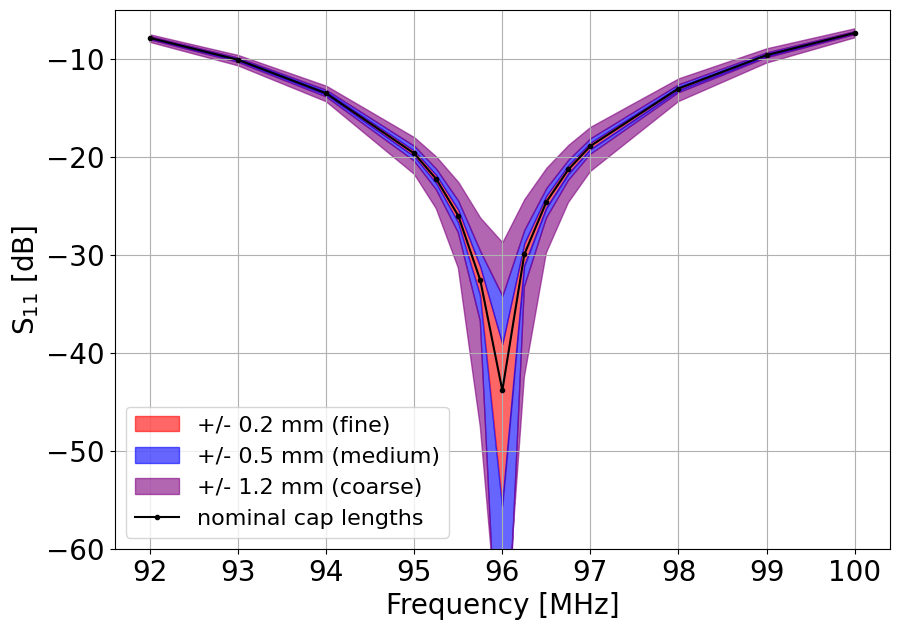

In [25]:
# plot
alpha = 0.6
min_S11_tol0 = np.min(S11_mat_tol0, axis=0)
max_S11_tol0 = np.max(S11_mat_tol0, axis=0)
min_S11_tol1 = np.min(S11_mat_tol1, axis=0)
max_S11_tol1 = np.max(S11_mat_tol1, axis=0)
min_S11_tol2 = np.min(S11_mat_tol2, axis=0)
max_S11_tol2 = np.max(S11_mat_tol2, axis=0)

fig, ax = plt.subplots(figsize=(10,7))

# tol0
plt.fill_between(myrfTWA_tolerence_study.freqs_for_fullant, min_S11_tol0, max_S11_tol0, color='red', alpha=alpha, label=f'+/- {tol0*1000} mm (fine)')

# tol1
plt.fill_between(myrfTWA_tolerence_study.freqs_for_fullant, max_S11_tol0, max_S11_tol1, color='blue', alpha=alpha, label=f'+/- {tol1*1000} mm (medium)')
plt.fill_between(myrfTWA_tolerence_study.freqs_for_fullant, min_S11_tol1, min_S11_tol0, color='blue', alpha=alpha)

# tol2
plt.fill_between(myrfTWA_tolerence_study.freqs_for_fullant, max_S11_tol1, max_S11_tol2, color='purple', alpha=alpha, label=f'+/- {tol2*1000} mm (coarse)')
plt.fill_between(myrfTWA_tolerence_study.freqs_for_fullant, min_S11_tol2, min_S11_tol1, color='purple', alpha=alpha)
plt.plot(myrfTWA_tolerence_study.freqs_for_fullant, S_11_nominal_response, color='black', label='nominal cap lengths', marker='.')
ax.legend(fontsize=16)
ax.grid()
#ax.set_ylim(0, np.pi)
ax.set_xlabel('Frequency [MHz]', fontsize=20)
ax.set_ylabel(r'S$_{11}$ [dB]', fontsize=20)
ax.set_ylim(-60,-5)
for label in ax.get_xticklabels():
    label.set_fontsize(20)          # set size

for label in ax.get_yticklabels():
    label.set_fontsize(20)          # set size

save_figure_data_to_hdf5(fig, 'figure27.h5')

In [ ]:
# make a simliar figure for nparallel plot, if it looks like it matches when you include the power magnitude


[-0.03898374+0.12820005j  0.01739169-0.18901427j  0.35728364-0.13048346j
 -0.11095332+0.25044149j -0.34309801+0.04643408j  0.14212086-0.33196153j
  0.3739052 +0.29538685j  0.14357567-0.33387049j -0.3433116 +0.0482778j
 -0.11118742+0.25203129j  0.35780609-0.13327607j  0.0162865 -0.1900382j
 -0.03801421+0.12896074j]
[0.13399621 0.18981271 0.380365   0.27391893 0.3462259  0.36110496
 0.47650655 0.3634329  0.34668949 0.27546762 0.38182157 0.19073481
 0.13444684]


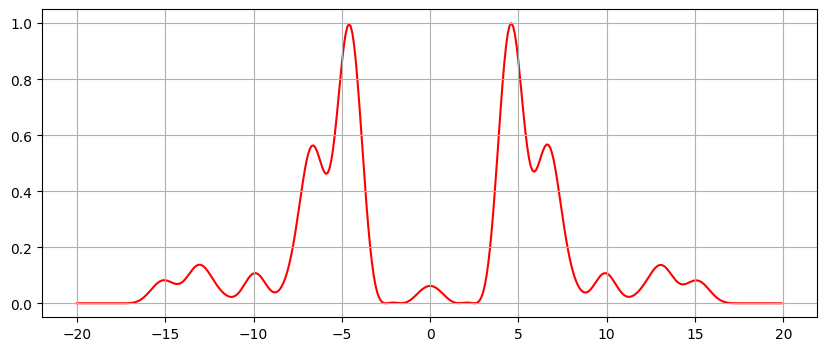

In [5]:
full_circ = myrfTWA_tolerence_study.get_fullant_given_lengths_from_internal_datatable(base_lengths_full.copy(), symetric_mode=False,
                    one_cap_type_mode=False,
                    end_cap_mode=False,
                    return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
# print('port indicies', full_circ.port_indexes)
# print(full_circ.currents(power,phase)[1,:])
# print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA_tolerence_study.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad
strap_phases = get_phase(strap_current_array)
strap_mags = np.abs(strap_current_array)
print(strap_mags)

npar_array = np.arange(-20, 20, .1)


result_circ_model = np.array([], dtype='complex')
# for i in range(npar_array.shape[0]):
#     power = myrfTWA_tolerence_study.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA_tolerence_study.geometry_dict['wstrap'],
#                                                                 d_strap=myrfTWA_tolerence_study.geometry_dict['d'],
#                                                                 freq=freq,
#                                                                 phase_array=strap_phases,
#                                                                 magnitude_array=strap_mags)
#     result_circ_model = np.append(result_circ_model, power)

for i in range(npar_array.shape[0]):
    power = myrfTWA_tolerence_study.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=.08*2,
                                                                d_strap=myrfTWA_tolerence_study.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases,
                                                                magnitude_array=strap_mags)
    result_circ_model = np.append(result_circ_model, power)
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', 
         label='result', zorder=1)